## Import Libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

import math
import os
import gc
import random
import pprint
import numpy as np               
import pandas as pd              
import matplotlib.pyplot as plt  
import seaborn as sns
import lifelines

import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import chi2
from sklearn.metrics import matthews_corrcoef

from collections import Counter
from scipy.stats import shapiro
from scipy import stats                        
from scipy.stats.contingency import association 
from lifelines import KaplanMeierFitter

import multiprocessing
import pickle, joblib

from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

sns.set_style('whitegrid')

init_notebook_mode(connected=True)

%matplotlib inline

In [4]:
plt_params = {
    'axes.facecolor' : 'white',
}

plt.rcParams.update(plt_params)

In [5]:
SEED = 42

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

## Loading Dataset

In [7]:
df = pd.read_excel("Project_Data_Churn.xlsx")
df.head(20)

,CustomerID,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,tenure,ContentType,MultiDeviceAccess,...,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,Churn
0,LOHRYYC9E8,42,11.321950,475.521914,Basic,Electronic check,Yes,1,Movies,Yes,...,24.593361,25,Comedy,3.489465,7,Female,15,No,No,0
1,RIH7RFEZCS,95,12.810915,1217.036887,Standard,Electronic check,Yes,34,TV Shows,No,...,102.860795,21,Comedy,2.251860,3,Male,8,No,NaN,0
2,JB5J8X2UY1,6,NaN,91.583304,Standard,Credit card,Yes,2,TV Shows,No,...,10.512415,29,Fantasy,NaN,4,Male,14,No,Yes,1
3,Z4GZJIB90P,54,17.917819,967.562224,Basic,NaN,Yes,45,Movies,No,...,45.246834,45,Drama,1.275004,3,Male,12,No,NaN,0
4,B3BDJTW0L9,27,NaN,339.057244,Basic,Mailed check,No,2,TV Shows,No,...,94.310954,44,Comedy,3.236230,4,Female,18,No,NaN,0
5,5E4TQK5OVX,71,NaN,818.287054,Premium,Credit card,No,8,Movies,Yes,...,123.280794,30,Comedy,2.779614,6,Female,16,Yes,NaN,0
6,8VFNZ1M1I9,69,17.145910,1183.067820,Basic,NaN,No,22,Movies,Yes,...,86.122559,35,Sci-Fi,4.933494,6,Female,5,No,Yes,1
7,THKWUHOGUL,76,17.461875,1327.102526,Premium,Electronic check,No,10,Movies,Yes,...,137.557874,32,Fantasy,2.154737,9,Female,11,Yes,Yes,0
8,IGZ39O1ROC,8,NaN,NaN,Premium,Electronic check,No,28,Both,Yes,...,137.552942,16,Fantasy,NaN,3,Female,2,No,Yes,0
9,JHTQYVGRR4,26,19.699262,512.180802,Premium,Credit card,Yes,62,Both,Yes,...,164.073643,44,Drama,1.725700,4,Male,16,Yes,NaN,1


In [8]:
printmd(f"There are **{df.shape[0]}** rows,  **{df.shape[1]}** columns in the dataset")

There are **963** rows,  **22** columns in the dataset

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                963 non-null    object 
 1   AccountAge                963 non-null    int64  
 2   MonthlyCharges            759 non-null    float64
 3   TotalCharges              777 non-null    float64
 4   SubscriptionType          913 non-null    object 
 5   PaymentMethod             740 non-null    object 
 6   PaperlessBilling          963 non-null    object 
 7   tenure                    963 non-null    int64  
 8   ContentType               963 non-null    object 
 9   MultiDeviceAccess         963 non-null    object 
 10  DeviceRegistered          887 non-null    object 
 11  ViewingHoursPerWeek       963 non-null    float64
 12  AverageViewingDuration    963 non-null    float64
 13  ContentDownloadsPerMonth  963 non-null    int64  
 14  GenrePrefe

In [10]:
df.columns

Index(['CustomerID', 'AccountAge', 'MonthlyCharges', 'TotalCharges',
       'SubscriptionType', 'PaymentMethod', 'PaperlessBilling', 'tenure',
       'ContentType', 'MultiDeviceAccess', 'DeviceRegistered',
       'ViewingHoursPerWeek', 'AverageViewingDuration',
       'ContentDownloadsPerMonth', 'GenrePreference', 'UserRating',
       'SupportTicketsPerMonth', 'Gender', 'WatchlistSize', 'ParentalControl',
       'SubtitlesEnabled', 'Churn'],
      dtype='object')

# EDA

In [12]:
df.describe()

,AccountAge,MonthlyCharges,TotalCharges,tenure,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,WatchlistSize,Churn
count,963.000000,759.000000,777.000000,963.000000,963.000000,963.000000,963.000000,702.000000,963.000000,963.000000,963.000000
mean,57.515057,12.328262,714.052121,32.289720,21.029241,90.741877,24.694704,2.923945,4.455867,11.900312,0.175493
std,33.662575,4.260861,511.071322,24.853545,11.318164,49.923719,14.319572,1.165992,2.935706,7.117402,0.380586
min,1.000000,5.062339,11.582882,0.000000,0.315317,5.028412,0.000000,1.000181,0.000000,0.000000,0.000000
25%,29.000000,8.816669,318.425396,8.000000,11.621961,47.777701,13.000000,1.922235,2.000000,6.000000,0.000000
50%,55.000000,12.169888,614.196606,29.000000,21.334100,89.878241,25.000000,2.898328,5.000000,12.000000,0.000000
75%,86.000000,15.937606,1021.436452,56.000000,30.419851,134.353824,37.000000,3.953953,7.000000,18.000000,0.000000
max,119.000000,19.932542,2261.019201,72.000000,39.949086,179.752024,49.000000,4.997348,9.000000,24.000000,1.000000


In [13]:
df.describe(include=['object']).T

,count,unique,top,freq
CustomerID,963,963,LOHRYYC9E8,1
SubscriptionType,913,3,Premium,333
PaymentMethod,740,4,Credit card,245
PaperlessBilling,963,2,No,506
ContentType,963,3,Both,349
MultiDeviceAccess,963,2,No,497
DeviceRegistered,887,4,Mobile,278
GenrePreference,853,5,Comedy,196
Gender,923,2,Male,541
ParentalControl,963,2,No,563


## Missing values

In [15]:
df.isnull().sum()

CustomerID                    0
AccountAge                    0
MonthlyCharges              204
TotalCharges                186
SubscriptionType             50
PaymentMethod               223
PaperlessBilling              0
tenure                        0
ContentType                   0
MultiDeviceAccess             0
DeviceRegistered             76
ViewingHoursPerWeek           0
AverageViewingDuration        0
ContentDownloadsPerMonth      0
GenrePreference             110
UserRating                  261
SupportTicketsPerMonth        0
Gender                       40
WatchlistSize                 0
ParentalControl               0
SubtitlesEnabled            800
Churn                         0
dtype: int64

In [16]:
numerical_features = ['MonthlyCharges', 'TotalCharges', 'UserRating', 'tenure']
categorical_features = ['SubscriptionType', 'PaymentMethod', 'DeviceRegistered', 'GenrePreference', 'Gender']

for col in numerical_features:
    if col in df.columns:
        df[col].fillna(df[col].mean(), inplace=True)

for col in categorical_features:
    if col in df.columns:
        df[col].fillna(df[col].mode()[0], inplace=True)
        
print("Remaining missing values in each column:\n")
print(df.isnull().sum())

Remaining missing values in each column:

CustomerID                    0
AccountAge                    0
MonthlyCharges                0
TotalCharges                  0
SubscriptionType              0
PaymentMethod                 0
PaperlessBilling              0
tenure                        0
ContentType                   0
MultiDeviceAccess             0
DeviceRegistered              0
ViewingHoursPerWeek           0
AverageViewingDuration        0
ContentDownloadsPerMonth      0
GenrePreference               0
UserRating                    0
SupportTicketsPerMonth        0
Gender                        0
WatchlistSize                 0
ParentalControl               0
SubtitlesEnabled            800
Churn                         0
dtype: int64


In [17]:
df.drop(['CustomerID', 'SubtitlesEnabled'], axis=1, inplace=True)

In [18]:
print(df.isnull().sum())

AccountAge                  0
MonthlyCharges              0
TotalCharges                0
SubscriptionType            0
PaymentMethod               0
PaperlessBilling            0
tenure                      0
ContentType                 0
MultiDeviceAccess           0
DeviceRegistered            0
ViewingHoursPerWeek         0
AverageViewingDuration      0
ContentDownloadsPerMonth    0
GenrePreference             0
UserRating                  0
SupportTicketsPerMonth      0
Gender                      0
WatchlistSize               0
ParentalControl             0
Churn                       0
dtype: int64


# Univariate Analysis

## Normality Test

Normality tests are used to determine if a dataset is normally distributed and to check how likely it is for a random variable in the dataset to be normally distributed.  
There are four numerical features in which we are interested - MonthlyCharges, Tenure, TotalCharges and UserRating.

Hypotheses -

H0: The data is normally distributed.  
H1: The data is not normally distributed.

In [23]:
for col in numerical_features:
    stat, p = shapiro(df[col])
    print(f"{col}:\n  Test Statistic = {stat:.4f}, p-value = {p:.4e}")
    if p < 0.05:
        print("Not normally distributed (reject H0)\n")
    else:
        print("Normally distributed (accept H0)\n")

MonthlyCharges:
  Test Statistic = 0.9672, p-value = 6.6039e-14
Not normally distributed (reject H0)

TotalCharges:
  Test Statistic = 0.9325, p-value = 1.9698e-20
Not normally distributed (reject H0)

UserRating:
  Test Statistic = 0.9567, p-value = 2.9039e-16
Not normally distributed (reject H0)

tenure:
  Test Statistic = 0.8992, p-value = 1.1896e-24
Not normally distributed (reject H0)



## Visualization

In [25]:
def plot_histogram(df, column_name):

  plt.figure(figsize=(5, 3))
  sns.histplot(df[column_name], kde=True)
  plt.title(f"Distribution of {column_name}")

  # calculate the mean and median values for the columns
  col_mean = df[column_name].mean()
  col_median = df[column_name].median()

  # add vertical lines for mean and median
  plt.axvline(col_mean, color="red", linestyle="--", label="Mean")
  plt.axvline(col_median, color="green", linestyle="-", label="Median")

  plt.legend()

  plt.show()

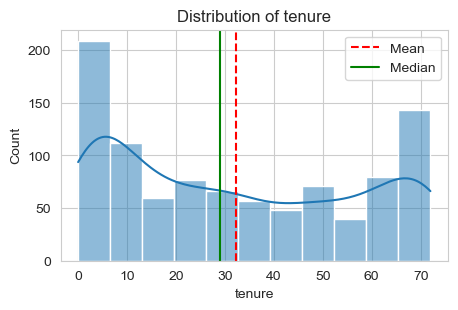

In [26]:
plot_histogram(df, "tenure")

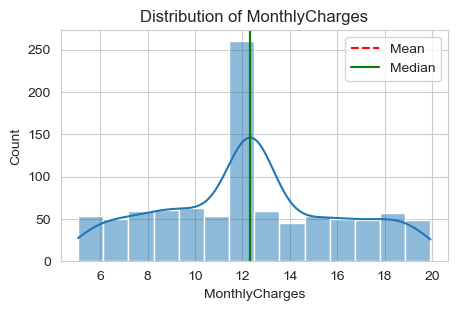

In [27]:
plot_histogram(df, "MonthlyCharges")

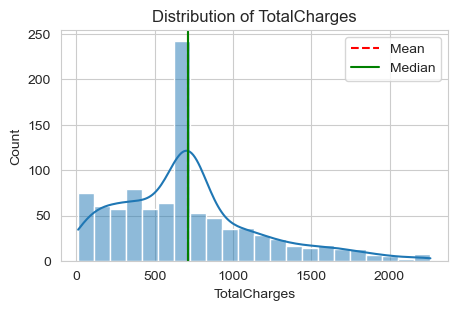

In [28]:
plot_histogram(df, "TotalCharges")

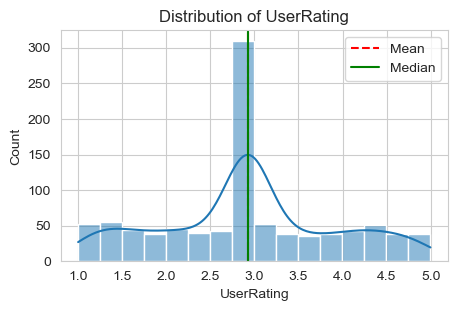

In [29]:
plot_histogram(df, "UserRating")

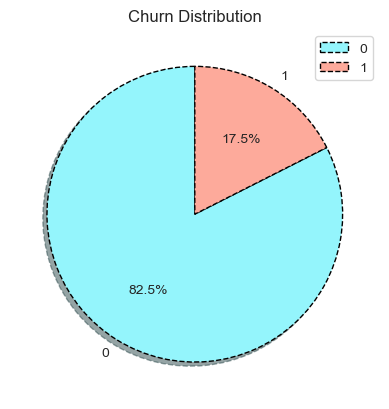

In [30]:
Churn_count = df["Churn"].value_counts()
plt.title("Churn Distribution")
plt.pie(Churn_count, labels=Churn_count.index, autopct='%1.1f%%', startangle=90, colors=["#94f5fc", "#fdaa9b"],shadow=True, wedgeprops={'edgecolor': 'black', 'linewidth':1, 'linestyle': '--'})
plt.legend()
plt.show()

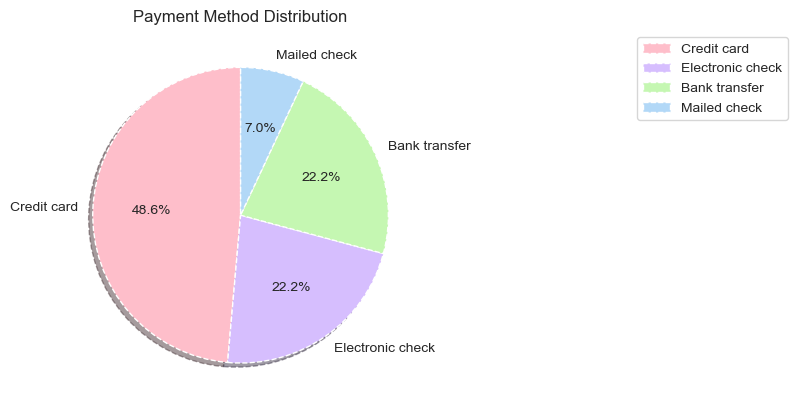

In [31]:
Payment_count = df["PaymentMethod"].value_counts()
plt.title("Payment Method Distribution")
plt.pie(Payment_count, labels=Payment_count.index, autopct='%1.1f%%', startangle=90, colors=["#febeca", "#d6befe", "#c5f7b2", "#b2d8f7"],shadow=True, wedgeprops={'edgecolor': 'white', 'linewidth':1, 'linestyle': '--'})
plt.legend(loc="upper right",bbox_to_anchor=(2, 1))
plt.show()

From this pie chart we can conclude most of the peaple make payment using credit card and equal number of people make payment using electronic check and bank transfer.

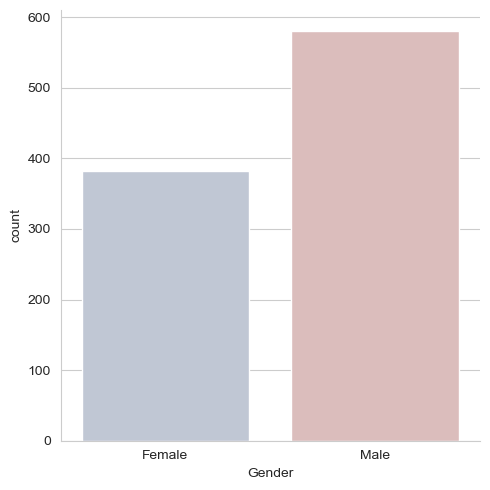

In [33]:
sns.catplot(x = "Gender", kind="count", data=df, palette="vlag")
plt.show()

Nunber of male grater than number of female

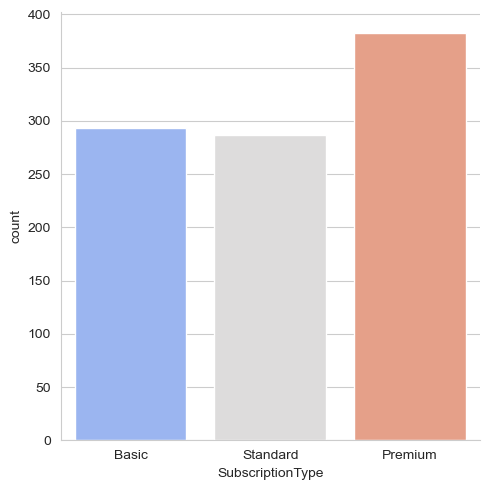

In [35]:
sns.catplot(x= "SubscriptionType", kind="count", data=df, palette= "coolwarm")
plt.show()

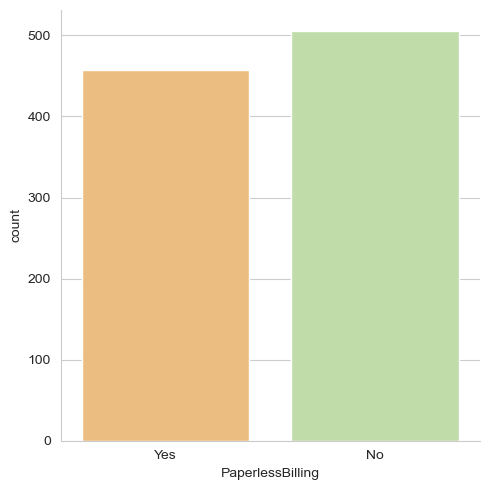

In [36]:
sns.catplot(x= "PaperlessBilling", kind="count", data=df, palette= "Spectral")
plt.show()

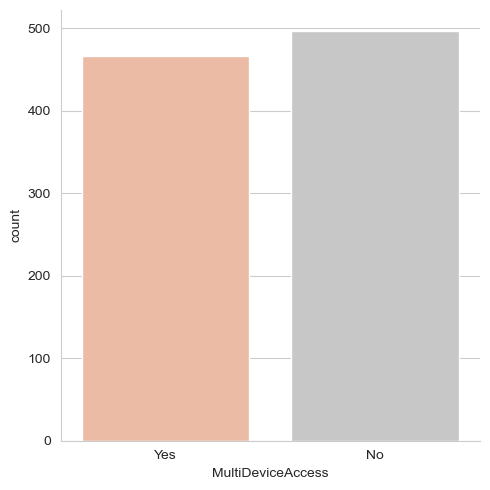

In [37]:
sns.catplot(x= "MultiDeviceAccess", kind="count", data=df, palette= "RdGy")
plt.show()

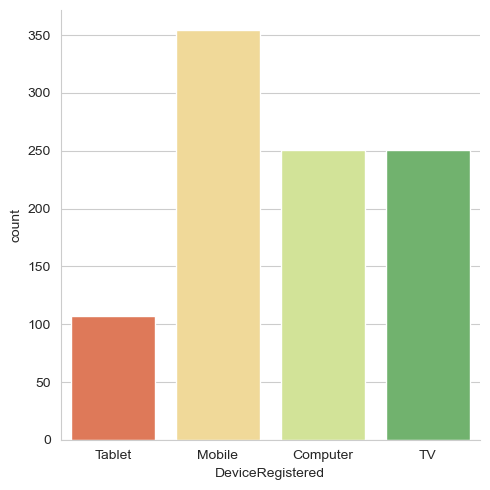

In [38]:
sns.catplot(x= "DeviceRegistered", kind="count", data=df, palette= "RdYlGn")
plt.show()

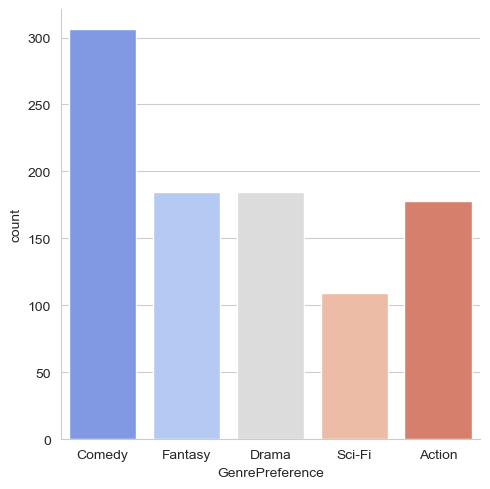

In [39]:
sns.catplot(x= "GenrePreference", kind="count", data=df, palette= "coolwarm")
plt.show()

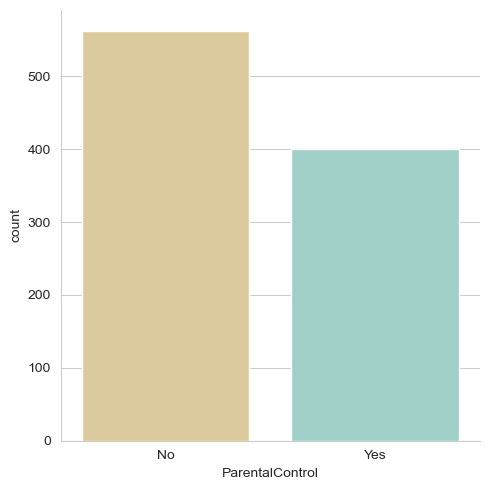

In [40]:
sns.catplot(x= "ParentalControl", kind="count", data=df, palette= "BrBG")
plt.show()

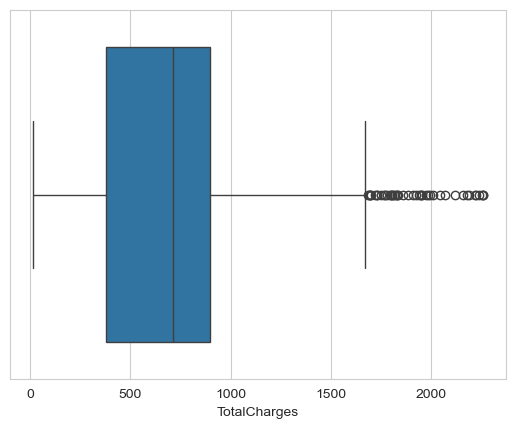

In [41]:
sns.boxplot(x = df["TotalCharges"])
plt.show()

In [42]:
def plot_histogram(feature):
    """Plots histogram and density plot of a variable."""
    
    fig = make_subplots(
        rows=2,
        cols=1,
        print_grid=False,
    subplot_titles=(f"Distribution of {feature.name} with Histogram", f"Distribution of {feature.name} with Density Plot"))
    
    fig.add_trace(
        go.Histogram(
            x = feature,
            hoverinfo="x+y"
        ),
    row=1,col=1)
    
    fig.add_trace(
        go.Histogram(
            x = feature,
            hoverinfo="x+y",
            histnorm = "density"
        ),
    row=2,col=1)
    
    fig.layout.update(
        height=800, 
        width=870,
        hovermode="closest"
        )
    
    fig.layout.yaxis1.update(title="<b>Abs Frequency</b>")
    fig.layout.yaxis2.update(title="<b>Density(%)</b>")
    fig.layout.xaxis2.update(title=f"<b>{feature.name}</b>")
    return fig.show()
plot_histogram(df['tenure'])

In [43]:
plot_histogram(df['MonthlyCharges'])

In [44]:
plot_histogram(df['TotalCharges'])

# Bivariate Analysis

## Spearman Rank Correlation

Unlike the Pearson correlation, the Spearman correlation does not assume that both datasets are normally distributed.  
Since  tenure, MonthlyCharges and TotalCharges columns are not normally distributed we are using Spearman Rank Correlation to find the correlation between them.

In [48]:
def corr(c1, c2):
    correlation = stats.spearmanr(df[c1], df[c2]).correlation
    print(f' correlation between {c1} and {c2} is {correlation}')


In [49]:
corr('tenure','MonthlyCharges')

 correlation between tenure and MonthlyCharges is 0.004808281696810439


In [50]:
corr('tenure','TotalCharges')

 correlation between tenure and TotalCharges is -0.04738400330857305


In [51]:
corr('MonthlyCharges','TotalCharges')

 correlation between MonthlyCharges and TotalCharges is 0.3504006163597486


### Mann-Whitney U Test

The Mann-Whitney U test is a nonparametric statistical significance test for determining whether two independent samples were drawn from a population with the same distribution. 
  
H0: Sample distributions are equal. (or sample distributions are likely drawn from the same population)  
H1: Sample distributions are not equal.  
  

In [54]:
def mannwhitneyu(f1):
    stat, p_value = stats.mannwhitneyu(df[f1], (df['Churn'] == 1))
    print(f"Association between {f1} and Churn")
    print('U-Statistics = %.5f, p = %.5f' % (stat, p_value))
    
    alpha = 0.05
    if p_value > alpha:
        print('Sample distribution are equal')
    else:
        print('Sample distribution are not equal')
    print('\n') 
features = ['tenure','MonthlyCharges', 'TotalCharges']

for num in features:
    printmd(f"Association with **{num}**")
    mannwhitneyu(num)

Association with **tenure**

Association between tenure and Churn
U-Statistics = 918742.00000, p = 0.00000
Sample distribution are not equal




Association with **MonthlyCharges**

Association between MonthlyCharges and Churn
U-Statistics = 927369.00000, p = 0.00000
Sample distribution are not equal




Association with **TotalCharges**

Association between TotalCharges and Churn
U-Statistics = 927369.00000, p = 0.00000
Sample distribution are not equal




### Chi-Square Test

Here we are using Chi-Square test to detect independence between churn and other categorical variables.  
  
Hypothesis:  
H0: variable is dependent with churn.  
vs  
H1: variable is not dependent with churn.  
  
If Statistic >= Critical Value: reject null hypothesis (H0), dependent.  
If Statistic < Critical Value: fail to reject null hypothesis (H0), independent.  
  
    
In terms of a p-value and a chosen significance level (alpha):  
  
If p-value <= alpha: reject null hypothesis (H0), dependent.  
If p-value > alpha: fail to reject null hypothesis (H0), independent.

In [57]:
df['churn'] = df['Churn'].astype('category') 

def chi_square(f1, f2='churn'):
    printmd(f"Correlation between **{f1}** and **{f2}**")
    crosstab = pd.crosstab(df[f1], df[f2])
    
    test_statistic, p, dof, expected = stats.chi2_contingency(crosstab,correction=True)
    
    
    print(f'p-value : {p}, degree of freedom: {dof}')

    # interpret test-statistic
    prob = 0.95
    critical_value = stats.chi2.ppf(prob, dof)
    print('probability=%.3f, critical_value=%.3f, test_statistic=%.3f' % (prob, critical_value, test_statistic))

    if abs(test_statistic) >= critical_value:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

    print("\n")
    # interpret p-value
    print("using p-value Test")
    
    alpha = 1.0 - prob

    print('significance_level=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    print('-----------------------------------\n')

features2 = ["Gender", "PaperlessBilling", "PaymentMethod", "SubscriptionType", "ContentType", "MultiDeviceAccess", "DeviceRegistered", "GenrePreference"]
for f in features2:
    print("\n")
    chi_square(f)

Correlation between **Gender** and **churn**

p-value : 1.0, degree of freedom: 1
probability=0.950, critical_value=3.841, test_statistic=0.000
Independent (fail to reject H0)


using p-value Test
significance_level=0.050, p=1.000
Independent (fail to reject H0)
-----------------------------------





Correlation between **PaperlessBilling** and **churn**

p-value : 0.8255021559555551, degree of freedom: 1
probability=0.950, critical_value=3.841, test_statistic=0.049
Independent (fail to reject H0)


using p-value Test
significance_level=0.050, p=0.826
Independent (fail to reject H0)
-----------------------------------





Correlation between **PaymentMethod** and **churn**

p-value : 0.22892069884843222, degree of freedom: 3
probability=0.950, critical_value=7.815, test_statistic=4.320
Independent (fail to reject H0)


using p-value Test
significance_level=0.050, p=0.229
Independent (fail to reject H0)
-----------------------------------





Correlation between **SubscriptionType** and **churn**

p-value : 0.7497123716714941, degree of freedom: 2
probability=0.950, critical_value=5.991, test_statistic=0.576
Independent (fail to reject H0)


using p-value Test
significance_level=0.050, p=0.750
Independent (fail to reject H0)
-----------------------------------





Correlation between **ContentType** and **churn**

p-value : 0.2531410277505337, degree of freedom: 2
probability=0.950, critical_value=5.991, test_statistic=2.748
Independent (fail to reject H0)


using p-value Test
significance_level=0.050, p=0.253
Independent (fail to reject H0)
-----------------------------------





Correlation between **MultiDeviceAccess** and **churn**

p-value : 0.4236253466431831, degree of freedom: 1
probability=0.950, critical_value=3.841, test_statistic=0.640
Independent (fail to reject H0)


using p-value Test
significance_level=0.050, p=0.424
Independent (fail to reject H0)
-----------------------------------





Correlation between **DeviceRegistered** and **churn**

p-value : 0.34785460354563463, degree of freedom: 3
probability=0.950, critical_value=7.815, test_statistic=3.298
Independent (fail to reject H0)


using p-value Test
significance_level=0.050, p=0.348
Independent (fail to reject H0)
-----------------------------------





Correlation between **GenrePreference** and **churn**

p-value : 0.7045001342315725, degree of freedom: 4
probability=0.950, critical_value=9.488, test_statistic=2.170
Independent (fail to reject H0)


using p-value Test
significance_level=0.050, p=0.705
Independent (fail to reject H0)
-----------------------------------



# Visualization

#### Tenure and MonthlyCharges Distribution

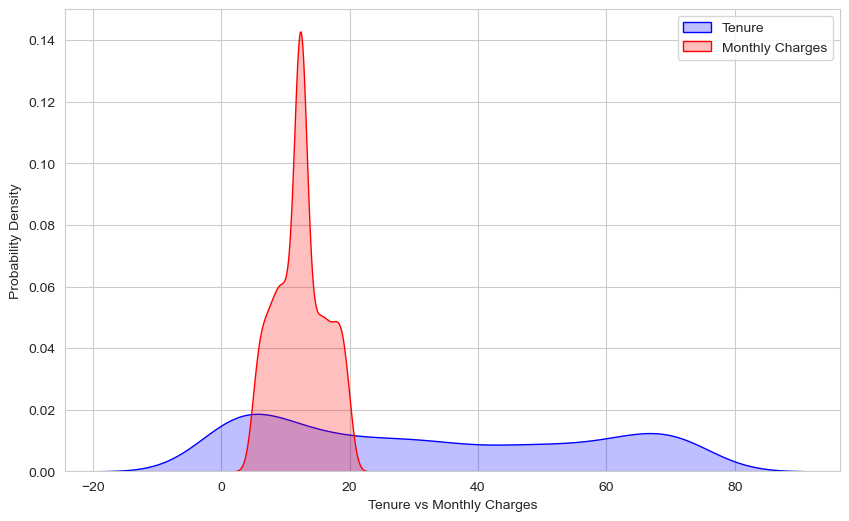

In [60]:
plt.figure(figsize=(10,6),dpi=100)
sns.kdeplot(df.tenure, color='b', shade=True, label='Tenure')
sns.kdeplot(df.MonthlyCharges, color='r', shade=True, label='Monthly Charges')
  
plt.xlabel('Tenure vs Monthly Charges')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


In [61]:
print(" Both are are not normally distributed Tenure has a Bimodal distribution. \n Most users stayed for less than 20 months Monthly Charges for most people is nearly 10 and 70 unit.")

 Both are are not normally distributed Tenure has a Bimodal distribution. 
 Most users stayed for less than 20 months Monthly Charges for most people is nearly 10 and 70 unit.


#### Gender, TotalCharges and Churn

In [63]:
sns.catplot(x = 'Churn',y = 'TotalCharges', col = 'Gender', data=df, kind='bar', aspect=.6, palette='Set2')

#### Checking Outliers

In [65]:
px.box(df, x= "Churn", y= "MonthlyCharges")

In [66]:
px.box(df, x= "Churn", y= "TotalCharges")

In [67]:
px.box(df, x= "Churn", y= "tenure")

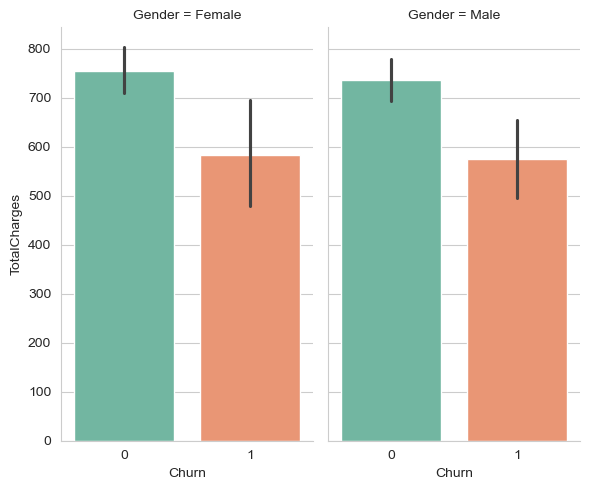

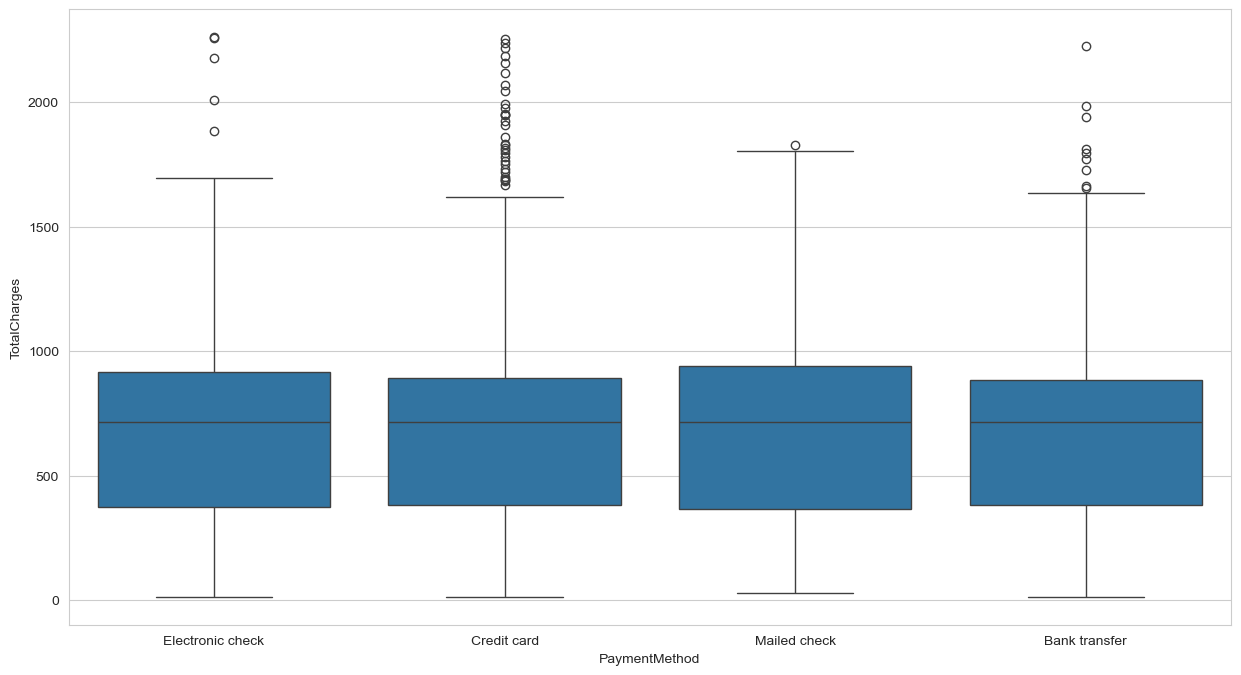

In [68]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x= "PaymentMethod", y= "TotalCharges", data=df)
plt.show()

In [69]:
printmd("**Total Charges for many users are in extreme level in credit card payment method**")

**Total Charges for many users are in extreme level in credit card payment method**

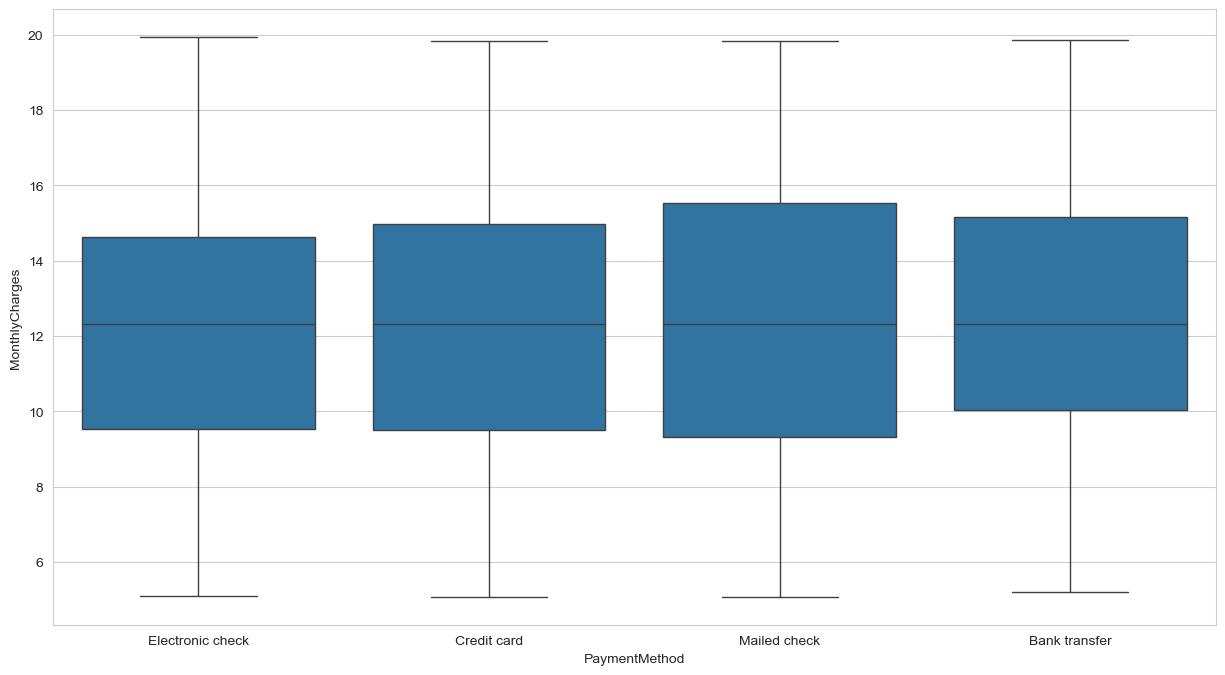

In [70]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x= "PaymentMethod", y= "MonthlyCharges", data=df)
plt.show()

# Multivariate Analysis

### Multicollinearity (Kruskal–Wallis)

Kruskal–Wallis test is more commonly used when we have three or more levels.  
  
Hypothses -  
H0: All sample distributions are equal.  
H1: sample distributions are not equal.

In [74]:

def K_W(f1, f2, f3):
    test_statistic, p = stats.kruskal(df[f1], df[f2], df[f3])
    print('test_statistics=%.3f, p=%.3f' % (test_statistic, p))
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')


In [75]:
K_W("TotalCharges", "tenure", "MonthlyCharges")

test_statistics=1952.491, p=0.000
Different distributions (reject H0)


In [76]:
K_W("MultiDeviceAccess", "DeviceRegistered", "PaymentMethod")

test_statistics=1683.900, p=0.000
Different distributions (reject H0)


In [77]:
K_W("SubscriptionType", "ContentType", "GenrePreference")

test_statistics=275.242, p=0.000
Different distributions (reject H0)


# Correlation Heatmap

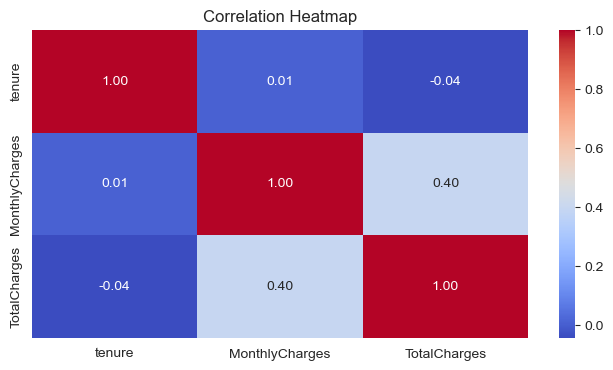

In [79]:
plt.figure(figsize=(8, 4))
sns.heatmap(df[["tenure", "MonthlyCharges", "TotalCharges"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

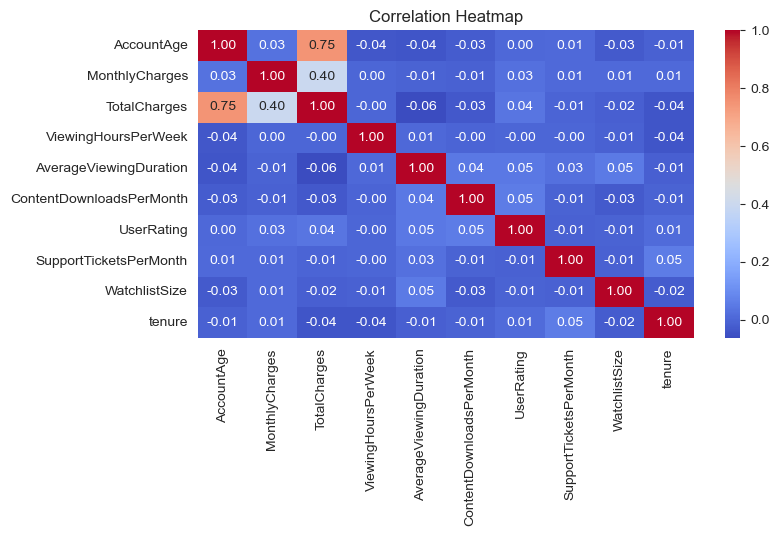

In [80]:
numerical_feachers_list  = ["AccountAge", "MonthlyCharges", "TotalCharges", "ViewingHoursPerWeek", "AverageViewingDuration", "ContentDownloadsPerMonth", "UserRating", "SupportTicketsPerMonth", "WatchlistSize", "tenure"]
#correlation_matrix = numerical_feachers_list.corr()
plt.figure(figsize=(8, 4))
sns.heatmap(df[numerical_feachers_list].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#### Frequency Distribution

In [82]:
def multivariate_analysis(v1, v2, v3, target_variable = df.Churn):
    
    fig,ax = plt.subplots(1,1,figsize = (18,5))
    font_size = 15
    grouped_by_target = pd.crosstab(index = [v1, v2, v3], columns = target_variable, normalize = "index")*100                            
    
    grouped_by_target.rename({"Yes":"% Churn", "No":"% Not Churn"}, axis = 1, inplace = True)
    grouped_by_target.plot.bar(color = ["green", "red"],ax=ax)
    ax.set_xlabel(f"{v1.name}, {v2.name}, {v3.name}", fontsize = font_size)
    ax.set_ylabel("Relative Frequency(%)", fontsize = font_size)
    ax.tick_params(axis="x", labelsize=font_size)
    ax.tick_params(axis="y", labelsize=font_size)
    plt.legend(loc = "best")
    return plt.show()

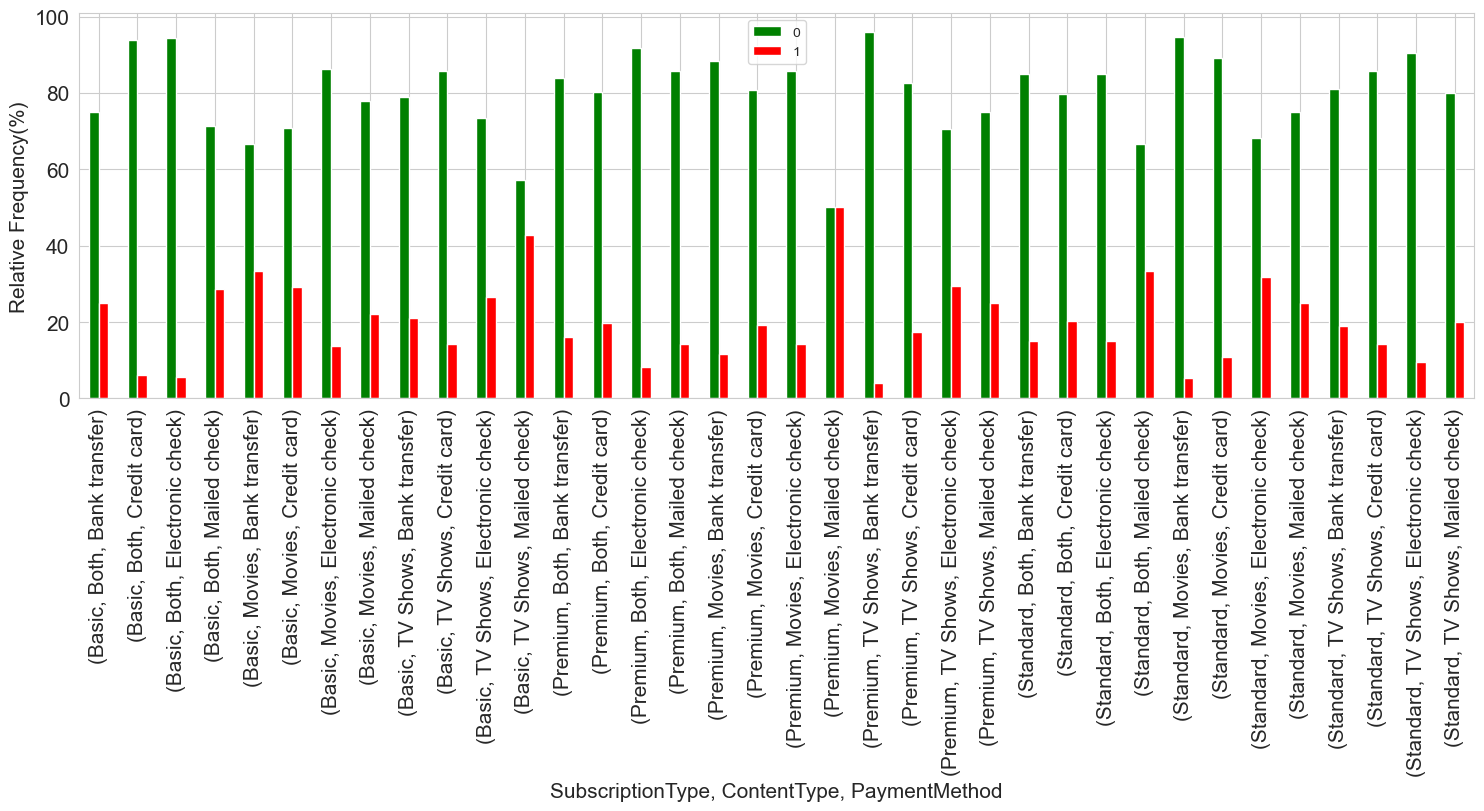

In [83]:
multivariate_analysis(df.SubscriptionType, df.ContentType, df.PaymentMethod)

In [84]:
printmd("**Most of the users who churned had a premium subscription intrested in movies and pay using mailed check**")

**Most of the users who churned had a premium subscription intrested in movies and pay using mailed check**

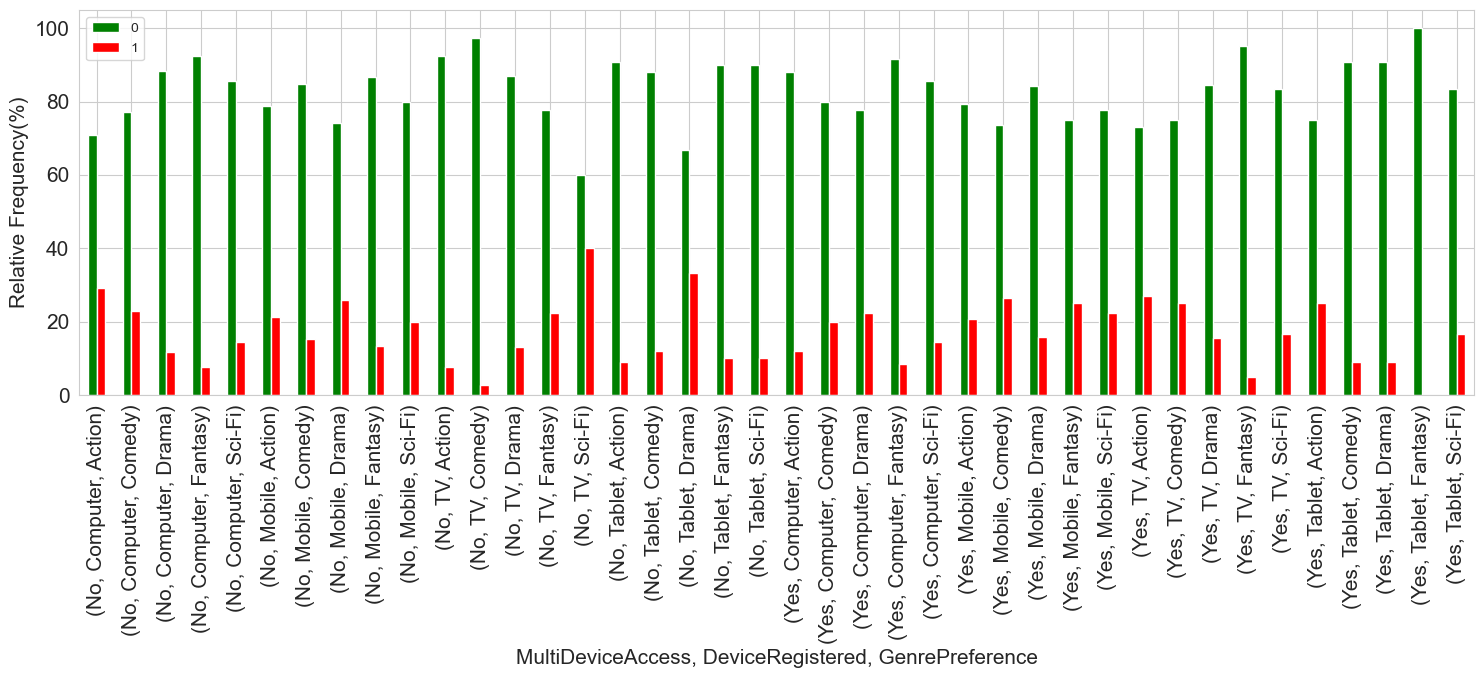

In [85]:
multivariate_analysis(df.MultiDeviceAccess, df.DeviceRegistered, df.GenrePreference)

In [86]:
printmd("**Most of the users who churned had not multidevice access, use TV and prefer Sci-Fi**")

**Most of the users who churned had not multidevice access, use TV and prefer Sci-Fi**

# Survival Analysis

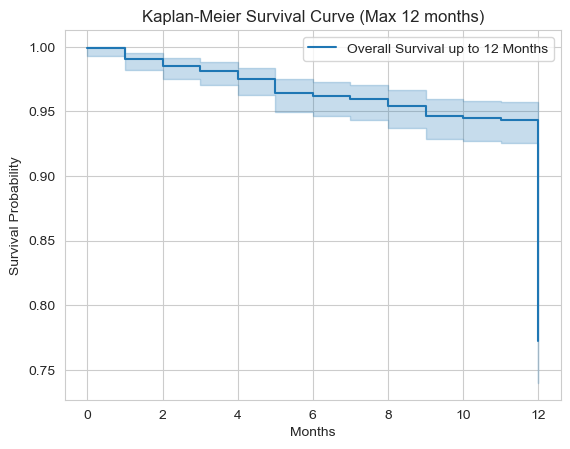

In [88]:
df['event'] = df['Churn']
df['tenure'] = df['tenure'].clip(upper = 12)

kmf = KaplanMeierFitter()

T = df['tenure'] 
E = df['event']  

kmf.fit(durations=T, event_observed=E, label= "Overall Survival up to 12 Months")
kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curve (Max 12 months)")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()